# For historical tornadoes, find closest NEXRAD radar site 

In [1]:
import numpy as np
import pandas as pd

## Read all the data
#### tornado file trimmed down from the 1950-2019 file at https://www.spc.noaa.gov/wcm/#data
Description of [format](https://www.spc.noaa.gov/wcm/data/SPC_severe_database_description.pdf)

In [129]:
tornadoes = pd.read_csv('~/Box/MPO624_data/1991-2019_all_tornadoes.csv')
tornadoes

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,1,1991,1,14,1/14/91,17:00:00,3,TX,48,1,...,1.00,100,1,1,1,287,0,0,0,0
1,2,1991,1,14,1/14/91,17:50:00,3,TX,48,2,...,0.20,20,1,1,1,21,0,0,0,0
2,3,1991,1,14,1/14/91,18:14:00,3,TX,48,3,...,5.00,60,1,1,1,21,0,0,0,0
3,4,1991,1,14,1/14/91,18:18:00,3,TX,48,4,...,1.50,250,1,1,1,89,0,0,0,0
4,5,1991,1,14,1/14/91,18:18:00,3,TX,48,5,...,0.50,50,1,1,1,481,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36366,618537,2019,12,29,12/29/19,16:03:00,3,MS,28,0,...,7.70,900,1,1,1,7,0,0,0,0
36367,618538,2019,12,29,12/29/19,16:13:00,3,MS,28,0,...,3.82,200,1,1,1,19,0,0,0,0
36368,618539,2019,12,29,12/29/19,16:32:00,3,MS,28,0,...,2.61,200,1,1,1,105,0,0,0,0
36369,618540,2019,12,29,12/29/19,17:13:00,3,MS,28,0,...,3.23,125,1,1,1,101,0,0,0,0


In [145]:
# Remove unwanted columns based on their names from this doc
# https://www.spc.noaa.gov/wcm/data/SPC_severe_database_description.pdf
tornadoes.drop(['om','tz','stf','stn','ns','sn','sg','f1','f2','f3','f4','fc'], axis=1, inplace=True)

In [146]:
tornadoes

,yr,mo,dy,date,time,st,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid
0,1991,1,14,1/14/91,17:00:00,TX,1,0,0,4.0,0.0,30.1800,-96.9300,0.0000,0.0000,1.00,100
1,1991,1,14,1/14/91,17:50:00,TX,0,0,0,2.0,0.0,29.9300,-97.3000,0.0000,0.0000,0.20,20
2,1991,1,14,1/14/91,18:14:00,TX,2,0,0,5.0,0.0,29.9800,-97.2000,30.0300,-97.1300,5.00,60
3,1991,1,14,1/14/91,18:18:00,TX,1,11,1,7.0,0.0,29.7200,-96.5500,0.0000,0.0000,1.50,250
4,1991,1,14,1/14/91,18:18:00,TX,1,0,0,5.0,0.0,29.3200,-96.1000,0.0000,0.0000,0.50,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36366,2019,12,29,12/29/19,16:03:00,MS,1,0,0,75000.0,0.0,33.1628,-89.4323,33.2339,-89.3298,7.70,900
36367,2019,12,29,12/29/19,16:13:00,MS,1,0,0,10000.0,0.0,33.2598,-89.2778,33.2879,-89.2208,3.82,200
36368,2019,12,29,12/29/19,16:32:00,MS,0,0,0,5000.0,0.0,33.4720,-89.0315,33.4888,-88.9910,2.61,200
36369,2019,12,29,12/29/19,17:13:00,MS,1,0,0,150000.0,0.0,32.5268,-89.1628,32.5581,-89.1215,3.23,125


In [147]:
# RADAR site locations from https://en.wikipedia.org/wiki/NEXRAD#cite_note-54

sites = pd.read_table('~/Box/MPO624_data/WSR88d_locations.txt')

In [148]:
sites[0:5]

,State,Name,Code,Lat,WestLon
0,PR,San Juan,TJUA,18.115600,66.078064
1,ME,Houlton,KCBW,46.039194,67.806603
2,ME,Gray/Portland,KGYX,43.891356,70.256554
3,VT,Burlington,KCXX,44.510994,73.166424
4,MA,Boston\t,KBOX,41.955892,71.136968


## Loop over tornadoes, calculate all site distances

In [149]:
# Starting longitude: how to get the value as a number, from Pandas

tornadoes[23:24]['slon'].values[0]

-82.47

In [150]:
# Site longitude, how to get the value as a number, from Pandas

sites[11:12]['WestLon'].values[0]

74.4108027

# OK, ready for the magic loop
## For each tornado, calculate distance of START POINT to nearest radar 

Add two columns to tornados DataFrame
1. that distance (so we can sort for the smallest value)
2. radar ID code

In [161]:
# Create a subset: wide ones that will look good in Doppler radar 

# Here's a neat trick: eval() and exec()
# https://stackoverflow.com/questions/701802/how-do-i-execute-a-string-containing-python-code-in-python

condition = 'tornadoes.wid>500'  # a string for filename and also the code to make it happen: safe!

subset = tornadoes[ eval(cond) ]
subset.reset_index(drop=True, inplace=True) #remove the old index number 
#subset.drop(['om','tz','stf','stn','ns','sn','sg','f1','f2','f3','f4','fc'], axis=1)

In [162]:
# Loop and collect Code and Distance lists
NearestCode = []
NearestDist = []

for i in range(len(subset)): 
    # print(subset[i:i+1]['st'].values[0]) # debugging/testing: print the state
    x = subset[i:i+1]['slon'].values[0]
    y = subset[i:i+1]['slat'].values[0]
    min_dist = 1e9 # start with a large value, and find the minimuum
    
    for j in range(len(sites)):
        # print(sites[j:j+1])
        # dx is distance eastward (using cos of latitude correction on sphere)
        dx = (x + sites[j:j+1]['WestLon'].values[0]) * np.cos(y*3.14/180.)
        dy = y - sites[j:j+1]['Lat'].values[0]
        dist2 = dx*dx + dy*dy
        
        if (dist2 < min_dist): 
            # print(sites[j:j+1], '   DISTANCE ', np.sqrt(dist2))
            min_dist = np.sqrt(dist2)
            closest = j 
    #print('') # debugging/testing
    #print('closest station, distance: ')
    #print(sites[closest:closest+1].values[0])
    #print('DISTANCE (km): ', min_dist*111.111)
    #print('')
    
    NearestDist.append(min_dist*111.111) # km 
    NearestCode.append(sites[closest:closest+1]['Code'].values[0])

# Append columns onto the DataFrame

In [163]:
subset['NearestRadar'] = NearestCode
subset['NearestDist'] = NearestDist

/var/folders/cx/744cq3h94zq66_v0ms6wg8m40000gn/T/ipykernel_39328/2670587935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['NearestRadar'] = NearestCode
/var/folders/cx/744cq3h94zq66_v0ms6wg8m40000gn/T/ipykernel_39328/2670587935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['NearestDist'] = NearestDist


In [170]:
subset.sort_values(by='NearestDist',inplace=True)

/var/folders/cx/744cq3h94zq66_v0ms6wg8m40000gn/T/ipykernel_39328/3853159215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.sort_values(by='NearestDist',inplace=True)


In [172]:
subset.reset_index(drop=True, inplace=True) #remove the old index number 
subset

,yr,mo,dy,date,time,st,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,NearestRadar,NearestDist
0,2015,5,16,5/16/15,22:43:00,OK,2,0,0,1.00,0.0,36.1719,-95.5700,36.2872,-95.4681,9.80,1500,KINX,0.624151
1,2019,4,13,4/13/19,22:22:00,MS,2,0,0,500000.00,0.0,33.8931,-88.3215,34.0831,-88.2901,13.20,800,KGWX,0.834936
2,2018,4,13,4/13/18,23:10:00,LA,1,0,1,7000000.00,0.0,32.4521,-93.8531,32.6070,-93.5129,22.54,1100,KSHV,1.117873
3,2008,4,3,4/3/08,21:06:00,AR,2,0,0,12.00,0.0,34.8100,-92.2700,34.8900,-92.1900,7.07,800,KLZK,3.032709
4,2003,4,24,4/24/03,20:53:00,MS,3,6,0,50.00,0.0,32.2500,-90.0000,32.3500,-89.8500,12.00,600,KDGX,3.605939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,2015,5,25,5/25/15,13:42:00,OK,3,1,1,0.00,0.0,33.9830,-96.2684,34.2308,-96.1856,18.80,700,KSRX,227.969035
1519,2011,4,21,4/21/11,17:45:00,TX,2,0,0,0.10,0.0,30.2045,-102.4450,30.1582,-102.3250,7.82,800,KDFX,232.240088
1520,2010,6,17,6/17/10,15:59:00,MN,4,20,0,0.00,0.0,46.4100,-95.1800,46.5216,-95.0260,10.00,1936,KDLH,232.538443
1521,2005,6,6,6/6/05,16:00:00,TX,1,0,0,0.28,0.0,31.4800,-95.4700,31.4800,-95.4700,6.00,850,KPOE,239.073260


In [174]:
filename = '~/Box/MPO624_data/1991-2019_tornadoes_'+condition+'_byRadarDistances.csv'
subset.to_csv(filename)

In [175]:
test = pd.read_csv(filename)
test

,Unnamed: 0,yr,mo,dy,date,time,st,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,NearestRadar,NearestDist
0,0,2015,5,16,5/16/15,22:43:00,OK,2,0,0,1.00,0.0,36.1719,-95.5700,36.2872,-95.4681,9.80,1500,KINX,0.624151
1,1,2019,4,13,4/13/19,22:22:00,MS,2,0,0,500000.00,0.0,33.8931,-88.3215,34.0831,-88.2901,13.20,800,KGWX,0.834936
2,2,2018,4,13,4/13/18,23:10:00,LA,1,0,1,7000000.00,0.0,32.4521,-93.8531,32.6070,-93.5129,22.54,1100,KSHV,1.117873
3,3,2008,4,3,4/3/08,21:06:00,AR,2,0,0,12.00,0.0,34.8100,-92.2700,34.8900,-92.1900,7.07,800,KLZK,3.032709
4,4,2003,4,24,4/24/03,20:53:00,MS,3,6,0,50.00,0.0,32.2500,-90.0000,32.3500,-89.8500,12.00,600,KDGX,3.605939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,1518,2015,5,25,5/25/15,13:42:00,OK,3,1,1,0.00,0.0,33.9830,-96.2684,34.2308,-96.1856,18.80,700,KSRX,227.969035
1519,1519,2011,4,21,4/21/11,17:45:00,TX,2,0,0,0.10,0.0,30.2045,-102.4450,30.1582,-102.3250,7.82,800,KDFX,232.240088
1520,1520,2010,6,17,6/17/10,15:59:00,MN,4,20,0,0.00,0.0,46.4100,-95.1800,46.5216,-95.0260,10.00,1936,KDLH,232.538443
1521,1521,2005,6,6,6/6/05,16:00:00,TX,1,0,0,0.28,0.0,31.4800,-95.4700,31.4800,-95.4700,6.00,850,KPOE,239.073260


-------------
# build the URL for Amazon data folder and make it a column 

In [176]:
###### needs to be in this format: 
# https://s3.amazonaws.com/noaa-nexrad-level2/index.html#1997/06/06/KAMA/
# NEEDS ZERO-PADDING # NEEDS TO BE 2 DIGITS

URLs = 'https://s3.amazonaws.com/noaa-nexrad-level2/index.html#' \
     + subset['yr'].astype('str') + '/' \
     + subset['mo'].astype('str') + '/' \
     + subset['dy'].astype('str') + '/' \
     + subset['NearestRadar']
URLs[0:1].values[0]

'https://s3.amazonaws.com/noaa-nexrad-level2/index.html#2015/5/16/KINX'

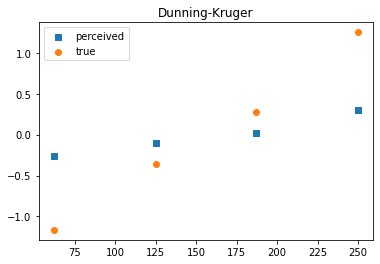

In [180]:
  import random
  import numpy as np

  np.random.seed(seed=12345)

  from scipy.linalg import eigh, cholesky
  from scipy.stats import norm
  from matplotlib import pyplot as plt

  #Draw correlated random variables
  #Ref here: https://scipy-cookbook.readthedocs.io/items/CorrelatedRandomSamples.html

  num_samples = 125 * 4                 #
  x = norm.rvs(size=(2, num_samples)) # uncorrelated random normal variables

  expected_correlation = np.array([[1.0, 0.19], [0.19, 1.0]])
  c = cholesky(expected_correlation, lower=True) #there's a slight correlation of R = 0.19 between actual and perceived scores (according to Ackerman, 2002)

  trans_x = np.dot(c, x)

  #perceived / actual readings with R=0.19
  perceived = trans_x[0, :]
  actual = trans_x[1, :]

  #Sort both variables by actual scores.
  sort_by_actual = sorted(range(num_samples), key = lambda idx: actual[idx])

  perceived_by_actual = [perceived[i] for i in sort_by_actual]
  actual_by_actual = [actual[i] for i in sort_by_actual]

  quartile_indices = [i * (num_samples // 4) for i in range(5)] #note: depends on divisiblity by four

  x_coords = [xx // 2 for xx in quartile_indices[1:]] #mid-points just for plotting
  perceived_means = [np.mean(perceived_by_actual[start:end]) for (start, end) in zip(quartile_indices[:-1], quartile_indices[1:])]
  actual_means = [np.mean(actual_by_actual[start:end]) for (start, end) in zip(quartile_indices[:-1], quartile_indices[1:])]

  #Plot
  fig = plt.figure()

  ax1 = fig.add_subplot(111)
  plt.title("Dunning-Kruger")

  ax1.scatter(x_coords, perceived_means, marker="s", label="perceived")
  ax1.scatter(x_coords, actual_means, marker="o", label="true")
  ax1.legend()

  plt.show()